# **Ensembling Boxes [NMS-Soft_NMS-NMW-WBF] Yolov5**

### Hi kagglers, This is `Ensembling Boxes methods` notebook using `YOLOv5`.



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# Impotring libraries 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import shutil
import sys
import torch
from PIL import Image
import ast

In [ ]:
CONF=0.15

In [ ]:
sys.path.append('../input/ensemble-boxes-104/ensemble_boxes-1.0.4')
from ensemble_boxes import *

In [ ]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolo-arial/Arial.ttf /root/.config/Ultralytics/

# Functions

In [ ]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]

    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    # converstion (xmid, ymid) => (xmin, ymin)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):

    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors

    if bbox_format == 'yolo':

        for idx in range(len(bboxes)):

            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors

            if cls in show_classes:

                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox,
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)

    elif bbox_format == 'coco':

        for idx in range(len(bboxes)):

            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors

            if cls in show_classes:
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox,
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':

        for idx in range(len(bboxes)):

            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors

            if cls in show_classes:
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox,
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def show_img(img, bboxes, bbox_format='yolo', bbox_colors = None):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes,
                           classes = names,
                           class_ids = labels,
                           class_name = True,
                           colors = colors if bbox_colors is None else bbox_colors,
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [ ]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('/kaggle/input/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000 
    return model

def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        classes  = preds.name.values
        return bboxes, confs,classes
    else:
        return [],[],[]

def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf= confs[idx]
#             if conf>0.15:
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

# def format_prediction(bboxes):
#     pred_strings = []
#     if len(bboxes)>0:
#         for bb in bboxes:
#             pred_strings.append(f'{bb[4]:.2f} {int(bb[0])} {int(bb[1])} {int(bb[2])} {int(bb[3])}')
#     return ' '.join(pred_strings)



# Ensembling 3 Models

In [ ]:
CKPT_PATH1 = '../input/reefbaselinefold12v2/l6_3600_uflip_vm5_f12_up/f1/best.pt'
CONF1      = 0.45
IOU1       = 0.5
CKPT_PATH2 = '../input/yolov5s6/f2_sub2.pt'
CONF2      = 0.45
IOU2       = 0.5
CKPT_PATH3 = '../input/yolov5/3000_fold0_all_10.pt'
CONF3      = 0.45
IOU3       = 0.5
CKPT_PATH4 = '../input/reefbaselinefold12v2/l6_3600_uflip_vm5_f12_up/f2/best.pt'
CONF4      = 0.45
IOU4       = 0.5
MIN_SZ    = 4
#--------------------------------------------------------------------------
model1 = load_model(CKPT_PATH1, conf=CONF1, iou=IOU1) 
model2 = load_model(CKPT_PATH2, conf=CONF2, iou=IOU2)
model3 = load_model(CKPT_PATH3, conf=CONF3, iou=IOU3)
model4 = load_model(CKPT_PATH4, conf=CONF4, iou=IOU4)

# Let's use image from validation set

In [ ]:
TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_2/5747.jpg"
img = cv2.imread(TEST_IMAGE_PATH)[...,::-1]
#--------------------------------------------------------------------------
IMG_SIZE  = 3000
IMG_SIZE1  = 3000
IMG_SIZE2  = 3000
IMG_SIZE3  = 3000
IMG_SIZE4  = 3000
AUGMENT   = True
#--------------------------------------------------------------------------
bboxes1, scores1 ,bbclasses1  = predict(model1, img, size=IMG_SIZE1, augment=AUGMENT)
bboxes2, scores2 ,bbclasses2  = predict(model2, img, size=IMG_SIZE2, augment=AUGMENT)
bboxes3, scores3 ,bbclasses3  = predict(model3, img, size=IMG_SIZE3, augment=AUGMENT)
bboxes4, scores4 ,bbclasses4  = predict(model4, img, size=IMG_SIZE4, augment=AUGMENT)
#--------------------------------------------------------------------------
out_image=draw_bboxes(img = img,
                        bboxes = bboxes1, 
                        classes = ["model1"]*len(bboxes1),
                        class_ids = [0]*len(bboxes1),
                        class_name = True, 
                        colors = (0,0,130), 
                        bbox_format = 'coco',
                        line_thickness = 2)

out_image=draw_bboxes(img = out_image,
                        bboxes = bboxes2, 
                        classes = ["  model2"]*len(bboxes2),
                        class_ids = [0]*len(bboxes2),
                        class_name = True, 
                        colors = (0,130,0), 
                        bbox_format = 'coco',
                        line_thickness = 2)
out_image=draw_bboxes(img = out_image,
                        bboxes = bboxes3, 
                        classes = ["   model3"]*len(bboxes3),
                        class_ids = [0]*len(bboxes3),
                        class_name = True, 
                        colors = (255,0,0), 
                        bbox_format = 'coco',
                        line_thickness = 2)
out_image=draw_bboxes(img = out_image,
                        bboxes = bboxes4, 
                        classes = ["   model4"]*len(bboxes4),
                        class_ids = [0]*len(bboxes4),
                        class_name = True, 
                        colors = (255,0,0), 
                        bbox_format = 'coco',
                        line_thickness = 2)

out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

In [ ]:
bboxes1[:, 2] = bboxes1[:, 2] + bboxes1[:, 0]
bboxes1[:, 3] = bboxes1[:, 3] + bboxes1[:, 1]
bboxes2[:, 2] = bboxes2[:, 2] + bboxes2[:, 0]
bboxes2[:, 3] = bboxes2[:, 3] + bboxes2[:, 1]
bboxes3[:, 2] = bboxes3[:, 2] + bboxes3[:, 0]
bboxes3[:, 3] = bboxes3[:, 3] + bboxes3[:, 1]
bboxes4[:, 2] = bboxes4[:, 2] + bboxes4[:, 0]
bboxes4[:, 3] = bboxes4[:, 3] + bboxes4[:, 1]

In [ ]:
def run_nms(bboxes, confs,classs, image_size, iou_thr=0.50, skip_box_thr=0.0001, weights=None):
    boxes =  [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(conf.shape[0]) for conf in confs]
    boxes, scores, labels = nms(boxes, scores, labels, weights=weights, iou_thr=iou_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

def run_nmw(bboxes, confs,classs, image_size, iou_thr=0.50, skip_box_thr=0.0001, weights=None):
    boxes =  [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(conf.shape[0]) for conf in confs]
    boxes, scores, labels = non_maximum_weighted(boxes, scores, labels, weights=weights, iou_thr=iou_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels


def run_soft_nms(bboxes, confs,classs, image_size, iou_thr=0.50, skip_box_thr=0.0001,sigma=0.1, weights=None):
    boxes =  [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(conf.shape[0]) for conf in confs]
    boxes, scores, labels = soft_nms(boxes, scores, labels, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

def run_wbf(bboxes, confs,classs, image_size, iou_thr=0.50, skip_box_thr=0.0001, weights=None):
    boxes =  [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(conf.shape[0]) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels
def check_result(bboxes,shape,score):
    if len(bboxes)==0:
        return []
    bboxes=np.array(bboxes)
    score = np.array(score)
    bboxes=bboxes[score>CONF]
    bboxes[bboxes<0]=0
    bboxes=bboxes[(bboxes[:,0]+bboxes[:,2]) < shape[1]]
    bboxes=bboxes[(bboxes[:,1]+bboxes[:,3]) < shape[0]]
    bboxes=bboxes[bboxes[:,2]>MIN_SZ]
    bboxes=bboxes[bboxes[:,3]>MIN_SZ]
    return bboxes

# Ensembling boxes methods [NMS-Soft_NMS-NMW-WBF]

Comparison was made for ensemble of 5 different object detection models predictions trained on Open Images Dataset (500 classes).
Model scores at local validation:
* Model 1: mAP(0.5) 0.5164
* Model 2: mAP(0.5) 0.5019
* Model 3: mAP(0.5) 0.5144
* Model 4: mAP(0.5) 0.5152
* Model 5: mAP(0.5) 0.4910

[Reference](http://https://github.com/ZFTurbo/Weighted-Boxes-Fusion)

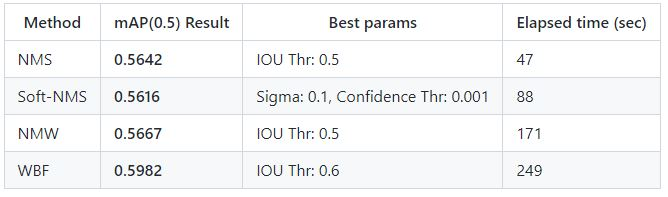

In [ ]:
#--------------------------------- Aug -----------------------------------------
iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.01
weights = [1.5, 2,0.5,1]
#--------------------------------- List -----------------------------------------
# boxes_list=[bboxes1,bboxes2]
# scores_list=[scores1,scores2]
# labels_list=[bbclasses1,bbclasses2]
boxes_list=[bboxes1,bboxes2,bboxes3,bboxes4]
scores_list=[scores1,scores2,scores3,scores4]
labels_list=[bbclasses1,bbclasses2,bbclasses3,bbclasses4]


##################################### soft_NMS #####################################
boxes, scores, labels  = run_soft_nms(boxes_list, scores_list, labels_list,IMG_SIZE, iou_thr,skip_box_thr,sigma,weights=weights)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
out_image_esemble=draw_bboxes(img = img,
                        bboxes = boxes, 
                        classes = ["soft_NMS"]*len(boxes),
                        class_ids = [0]*len(boxes),
                        class_name = True, 
                        colors = (0,150,0), 
                        bbox_format = 'coco',
                        line_thickness = 2)
out_image_esemble = cv2.cvtColor(out_image_esemble, cv2.COLOR_BGR2RGB)
print("------------------------------  SOFT_NMS   ---------------------------------------")
display(Image.fromarray(out_image_esemble))

#####################################  NMW  #####################################
boxes, scores, labels  = run_nmw(boxes_list, scores_list, labels_list,IMG_SIZE, iou_thr, skip_box_thr,weights=weights)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
out_image_esemble=draw_bboxes(img = img,
                        bboxes = boxes, 
                        classes = ["NMW"]*len(boxes),
                        class_ids = [0]*len(boxes),
                        class_name = True, 
                        colors = (0,0,255), 
                        bbox_format = 'coco',
                        line_thickness = 2)
out_image_esemble = cv2.cvtColor(out_image_esemble, cv2.COLOR_BGR2RGB)
print("------------------------------  NMW   ---------------------------------------")
display(Image.fromarray(out_image_esemble))



#####################################  WBF  #####################################
boxes, scores, labels  = run_wbf(boxes_list, scores_list,labels_list,IMG_SIZE, iou_thr, skip_box_thr,weights=weights)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
out_image_esemble=draw_bboxes(img = img,
                        bboxes = boxes, 
                        classes = ["WBF"]*len(boxes),
                        class_ids = [0]*len(boxes),
                        class_name = True, 
                        colors = (50,50,50), 
                        bbox_format = 'coco',
                        line_thickness = 2)
out_image_esemble = cv2.cvtColor(out_image_esemble, cv2.COLOR_BGR2RGB)
print("------------------------------  WBF   ---------------------------------------")
display(Image.fromarray(out_image_esemble))

# Inference

In [ ]:
%cd /kaggle/working/

In [ ]:
import greatbarrierreef
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [ ]:
Method ="WBF" # NMS,Soft-NMS,NMW or WBF
IMG_SIZE  = 3000
IMG_SIZE1  = 6000
IMG_SIZE2  = 6400
IMG_SIZE3  = 6000
IMG_SIZE4  = 3000
AUGMENT   = False
#--------------------------------------------------------------------------
# model1 = load_model(CKPT_PATH1, conf=CONF1, iou=IOU1) 
# model2 = load_model(CKPT_PATH2, conf=CONF2, iou=IOU2)
# model3 = load_model(CKPT_PATH3, conf=CONF3, iou=IOU3)
# model3 = load_model(CKPT_PATH3, conf=CONF3, iou=IOU3)
#--------------------------------------------------------------------------
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes1, scores1,bbclasses1  = predict(model1, img, size=IMG_SIZE1, augment=AUGMENT)
    bboxes2, scores2,bbclasses2  = predict(model2, img, size=IMG_SIZE2, augment=AUGMENT)
    bboxes3, scores3,bbclasses3  = predict(model3, img, size=IMG_SIZE3, augment=AUGMENT)
#     bboxes4, scores4,bbclasses4  = predict(model4, img, size=IMG_SIZE4, augment=AUGMENT)
    boxes_list=[]
    scores_list=[]
    labels_list=[]
    
    if len(bboxes1)>0:
        boxes_list.append(bboxes1)
        scores_list.append(scores1)
        labels_list.append(bbclasses1) 
        bboxes1[:, 2] = bboxes1[:, 2] + bboxes1[:, 0]
        bboxes1[:, 3] = bboxes1[:, 3] + bboxes1[:, 1]
    if len(bboxes2)>0:
        boxes_list.append(bboxes2)
        scores_list.append(scores2)
        labels_list.append(bbclasses2)
        bboxes2[:, 2] = bboxes2[:, 2] + bboxes2[:, 0]
        bboxes2[:, 3] = bboxes2[:, 3] + bboxes2[:, 1]
    if len(bboxes3)>0:
        boxes_list.append(bboxes3)
        scores_list.append(scores3)
        labels_list.append(bbclasses3)
        bboxes3[:, 2] = bboxes3[:, 2] + bboxes3[:, 0]
        bboxes3[:, 3] = bboxes3[:, 3] + bboxes3[:, 1]
#     if len(bboxes4)>0:
#         boxes_list.append(bboxes4)
#         scores_list.append(scores4)
#         labels_list.append(bbclasses4)
#         bboxes4[:, 2] = bboxes4[:, 2] + bboxes4[:, 0]
#         bboxes4[:, 3] = bboxes4[:, 3] + bboxes4[:, 1]

    if (len(bboxes1) + len(bboxes2) + len(bboxes3))>0:
        if Method =="NMS":
            boxes, scores, labels  = run_nms(boxes_list, scores_list, labels_list,IMG_SIZE, iou_thr=iou_thr,weights=weights)
        elif Method =="Soft-NMS":
            boxes, scores, labels  = run_soft_nms(boxes_list, scores_list, labels_list,IMG_SIZE, iou_thr,skip_box_thr,sigma,weights=weights)
        elif Method =="NMW":
            boxes, scores, labels  = run_nmw(boxes_list, scores_list, labels_list,IMG_SIZE, iou_thr, skip_box_thr,weights=weights)
        elif Method =="WBF":
            boxes, scores, labels  = run_wbf(boxes_list, scores_list,labels_list,IMG_SIZE, iou_thr, skip_box_thr,weights=weights)
        else:
            Method ="Only First Model(No Ensembling)"
            boxes, scores, labels  = bboxes1,scores1,bbclasses1 
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    else: boxes=[]
    boxes
    boxes = check_result(boxes,img.shape,scores)
    annot = format_prediction(boxes,scores)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    print("------------------------------  " + Method +"   ---------------------------------------")
    if idx<3:
        display(show_img(img, boxes, bbox_format='coco'))

In [ ]:
bboxes1

sub_df = pd.read_csv('submission.csv')
sub_df.head()